In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import utils
from PIL import Image

import torch
import torch.nn as nn
import torch.autograd as autograd

from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

In [53]:
transforms_train = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(1),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)) # normalization
])

data_dir = './Face-Mask-Classification-20000-Dataset/'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
print('Train dataset size:', len(train_dataset))

class_names = train_dataset.classes
print('Class names:', class_names)

Train dataset size: 18000
Class names: ['with_mask', 'without_mask']


In [54]:
import gc
gc.collect()
torch.cuda.empty_cache()

## acGAN

In [106]:
class acGenerator(nn.Module):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : FC1024_BR-FC7x7x128_BR-(64)4dc2s_BR-(1)4dc2s_S
    def __init__(self, input_dim=100, output_dim=1, input_size=64, class_num=2):
        super(acGenerator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.class_num = class_num
        
        self.label_embed = nn.Embedding(self.class_num, self.class_num)

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim + self.class_num, 512 * 4 * 4),
            nn.ReLU(),
        )
        
        self.deconv = nn.Sequential(
            nn.BatchNorm2d(512), # 채널의 크기와 동일
            nn.Upsample(scale_factor=2), # 너비와 높이 2배씩 증가
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), # 너비와 높이 유지
            nn.BatchNorm2d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(scale_factor=2), # 너비와 높이 2배씩 증가
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1), # 너비와 높이 유지, 채널의 크기는 256으로
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(scale_factor=2), # 너비와 높이 2배씩 증가
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1), # 너비와 높이 유지, 채널의 크기는 128로
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Upsample(scale_factor=2), # 너비와 높이 2배씩 증가
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1), # 너비와 높이 유지, 채널의 크기는 64로
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1), # 너비와 높이 유지, 채널의 크기는 3으로
            nn.Tanh(),
        )
        #utils.initialize_weights(self)

    def forward(self, noise, labels):
        x = torch.cat((noise, self.label_embed(labels)), -1)
        x = self.fc(x)
        x = x.view(-1, 512, 4, 4)
        x = self.deconv(x)

        return x

class acDiscriminator(nn.Module):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : (64)4c2s-(128)4c2s_BL-FC1024_BL-FC1_S
    def __init__(self, input_dim=100, output_dim=1, input_size=64, class_num=2):
        super(acDiscriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.class_num = class_num
        
        self.label_embed = nn.Embedding(self.class_num, 1 * 64 * 64)

        def make_block(in_channels, out_channels, bn=True):
            # 하나의 블록(block)을 반복할 때마다 너비와 높이는 2배씩 감소
            block = [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)]
            block.append(nn.LeakyReLU(0.2, inplace=True))
            block.append(nn.Dropout2d(0.25))
            if bn:
                block.append(nn.BatchNorm2d(out_channels, 0.8))
            return block

        # 너비와 높이가 32배씩 감소
        self.conv_blocks = nn.Sequential(
            *make_block(1, 16, bn=False),
            *make_block(16, 32),
            *make_block(32, 64),
            *make_block(64, 128),
        )
        '''
        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim + self.class_num, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            #nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.Linear(512 * 2 * 2, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.Sigmoid(),
        )

        '''
        # The height and width of downsampled image
        ds_size = 4
        
        # Output layers
        self.adv_layer = nn.Sequential(nn.Linear(512 * 2 * 2, 1), nn.Sigmoid())
        self.aux_layer = nn.Sequential(nn.Linear(512 * 2 * 2, 2), nn.Softmax())
        
    def forward(self, img):
        #print(img.shape)
        x = self.conv_blocks(img)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        validity = self.adv_layer(x)
        label = self.aux_layer(x)

        return validity, label

In [107]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


# 생성자(generator)와 판별자(discriminator) 초기화
acgan_generator = acGenerator()
acgan_discriminator = acDiscriminator()

acgan_generator.cuda()
acgan_discriminator.cuda()

# 가중치(weights) 초기화
acgan_generator.apply(weights_init_normal)
acgan_discriminator.apply(weights_init_normal)

# Loss functions
adversarial_loss = torch.nn.BCELoss()
auxiliary_loss = torch.nn.CrossEntropyLoss()
adversarial_loss.cuda()
auxiliary_loss.cuda()

# 학습률(learning rate) 설정
lr = 0.0001

# 생성자와 판별자를 위한 최적화 함수
optimizer_G = torch.optim.Adam(acgan_generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(acgan_discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [111]:
n_epochs = 15 # 학습의 횟수(epoch) 설정
latent_dim = 100
n_classes = 2
sample_interval = 500 # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정
start_time = time.time()

for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(train_dataloader):

        # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성
        valid = torch.cuda.FloatTensor(imgs.shape[0], 1).fill_(1.0) # 진짜(real): 1
        fake = torch.cuda.FloatTensor(imgs.shape[0], 1).fill_(0.0) # 가짜(fake): 0

        real_imgs = imgs.cuda()
        labels = labels.cuda()

        """ 생성자(generator)를 학습합니다. """
        optimizer_G.zero_grad()

        # 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
        z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).cuda()
        gen_labels = torch.randint(0, n_classes, (imgs.shape[0],)).cuda()

        # 이미지 생성
        gen_imgs = acgan_generator(z, gen_labels)
        
        # Loss measures generator's ability to fool the discriminator
        validity, pred_label = acgan_discriminator(gen_imgs)
        adversarial_loss(validity, valid)
        auxiliary_loss(pred_label, gen_labels)
        g_loss = 0.5 * (adversarial_loss(validity, valid) + auxiliary_loss(pred_label, gen_labels))

        # 생성자(generator) 업데이트
        g_loss.backward()
        optimizer_G.step()

        """ 판별자(discriminator)를 학습합니다. """
        optimizer_D.zero_grad()
        
        # Loss for real images
        real_pred, real_aux = acgan_discriminator(real_imgs)
        d_real_loss = (adversarial_loss(real_pred, valid) + auxiliary_loss(real_aux, labels)) / 2

        # Loss for fake images
        fake_pred, fake_aux = acgan_discriminator(gen_imgs.detach())
        d_fake_loss = (adversarial_loss(fake_pred, fake) + auxiliary_loss(fake_aux, gen_labels)) / 2

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2
        
        # Calculate discriminator accuracy
        pred = np.concatenate([real_aux.data.cpu().numpy(), fake_aux.data.cpu().numpy()], axis=0)
        gt = np.concatenate([labels.data.cpu().numpy(), gen_labels.data.cpu().numpy()], axis=0)
        d_acc = np.mean(np.argmax(pred, axis=1) == gt)

        # 판별자(discriminator) 업데이트
        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(train_dataloader) + i
        if done % sample_interval == 0:
            # 클래스당 8개의 이미지를 생성하여 2 X 8 격자 이미지에 출력
            z = torch.normal(mean=0, std=1, size=(n_classes * 8, latent_dim)).cuda()
            labels = torch.LongTensor([i for i in range(n_classes) for _ in range(8)]).cuda()
            generated_imgs = acgan_generator(z, labels)
            save_image(generated_imgs, f"./results/acgan/{done}.png", nrow=8, normalize=True)

    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [D acc: {100 * d_acc}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

[Epoch 0/15] [D loss: 0.504912] [D acc: 100.0] [G loss: 0.500168] [Elapsed time: 22.98s]
[Epoch 1/15] [D loss: 0.504930] [D acc: 100.0] [G loss: 0.510534] [Elapsed time: 45.81s]
[Epoch 2/15] [D loss: 0.503702] [D acc: 100.0] [G loss: 0.504413] [Elapsed time: 68.44s]
[Epoch 3/15] [D loss: 0.503680] [D acc: 100.0] [G loss: 0.510934] [Elapsed time: 91.24s]
[Epoch 4/15] [D loss: 0.501858] [D acc: 100.0] [G loss: 0.499517] [Elapsed time: 113.87s]
[Epoch 5/15] [D loss: 0.499285] [D acc: 100.0] [G loss: 0.504598] [Elapsed time: 136.58s]
[Epoch 6/15] [D loss: 0.504020] [D acc: 100.0] [G loss: 0.504975] [Elapsed time: 159.44s]


KeyboardInterrupt: 

In [20]:
'''
# 모델 파라미터 저장
torch.save(infogan_generator.state_dict(), "infoGAN_Generator_for_Face_Mask.pt")
torch.save(infogan_discriminator.state_dict(), "infoGAN_Discriminator_for_Face_Mask.pt")
print("Model saved!")
'''

Model saved!


In [56]:
# 생성자(generator) 초기화
infogan_generator = infoGenerator()
infogan_generator.cuda()
infogan_generator.load_state_dict(torch.load("infoGAN_Generator_for_Face_Mask.pt"))
infogan_generator.eval()

infoGenerator(
  (label_embed): Embedding(2, 2)
  (fc): Sequential(
    (0): Linear(in_features=102, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=32768, bias=True)
    (4): BatchNorm1d(32768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (deconv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Tanh()
  )
)

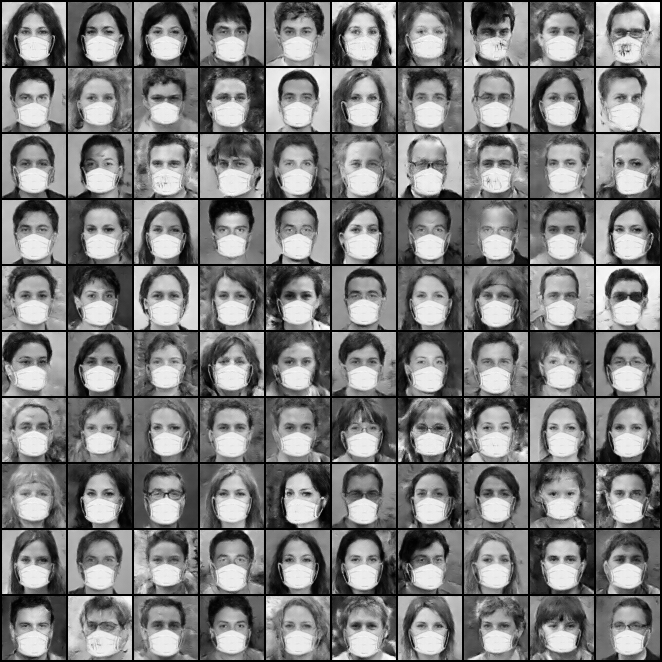

In [23]:
from IPython.display import Image as Display

# 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
z = torch.normal(mean=0, std=1, size=(100, latent_dim)).cuda()
generated_labels = torch.cuda.IntTensor(100).fill_(0)

# 이미지 생성
generated_imgs = infogan_generator(z, generated_labels)

# 생성된 이미지 중에서 100개를 선택하여 10 X 10 격자 이미지에 출력
save_image(generated_imgs.data[:100], f'./results/infogan/with_mask.png', nrow=10, normalize=True)

Display('./results/infogan/with_mask.png')

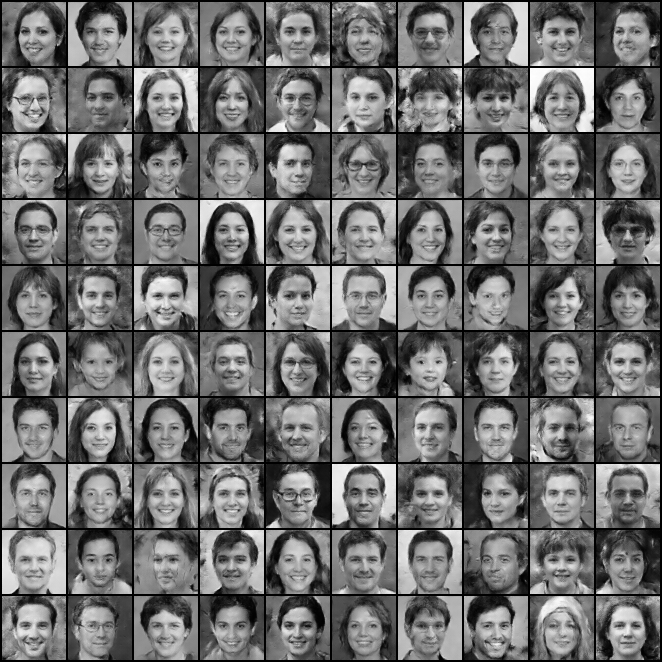

In [25]:
from IPython.display import Image as Display

# 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
z = torch.normal(mean=0, std=1, size=(100, latent_dim)).cuda()
generated_labels = torch.cuda.IntTensor(100).fill_(1)

# 이미지 생성
generated_imgs = infogan_generator(z, generated_labels)

# 생성된 이미지 중에서 100개를 선택하여 10 X 10 격자 이미지에 출력
save_image(generated_imgs.data[:100], f'./results/infogan/with_no_mask.png', nrow=10, normalize=True)

Display('./results/infogan/with_no_mask.png')

In [59]:
from IPython.display import Image as Display


# 마스크를 착용한 총 10 * 100개의 얼굴 이미지를 생성
for i in range(10):
    # 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
    z = torch.normal(mean=0, std=1, size=(100, latent_dim)).cuda()
    generated_labels = torch.cuda.IntTensor(100).fill_(0)
    # 이미지 생성
    generated_imgs = infogan_generator(z, generated_labels)

    for j in range(100):
        save_image(generated_imgs.data[j], f'./results/infogan/with_mask/{i * 100 + j}.png', normalize=True)


# 마스크를 착용한 총 10 * 100개의 얼굴 이미지를 생성
for i in range(10):
    # 랜덤 노이즈(noise) 및 랜덤 레이블(label) 샘플링
    z = torch.normal(mean=0, std=1, size=(100, latent_dim)).cuda()
    generated_labels = torch.cuda.IntTensor(100).fill_(1)
    # 이미지 생성
    generated_imgs = infogan_generator(z, generated_labels)

    for j in range(100):
        save_image(generated_imgs.data[j], f'./results/infogan/without_mask/{i * 100 + j}.png', normalize=True)

In [60]:
!python ./pytorch-frechet-inception-distance/fid.py --path1 ./results/infogan/without_mask --path2 ./Face-Mask-Classification-20000-Dataset/test/without_mask --batch-size 16

Looking for images in ./results/infogan/without_mask\*.png
Looking for images in ./results/infogan/without_mask\*.jpg
Looking for images in ./Face-Mask-Classification-20000-Dataset/test/without_mask\*.png
Looking for images in ./Face-Mask-Classification-20000-Dataset/test/without_mask\*.jpg
144.1131756256586


In [33]:
!python ./pytorch-frechet-inception-distance/fid.py --path1 ./results/infogan/with_mask --path2 ./Face-Mask-Classification-20000-Dataset/test/with_mask --batch-size 16

Looking for images in ./results/infogan/with_mask\*.png
Looking for images in ./results/infogan/with_mask\*.jpg
Looking for images in ./Face-Mask-Classification-20000-Dataset/test/with_mask\*.png
Looking for images in ./Face-Mask-Classification-20000-Dataset/test/with_mask\*.jpg
89.15576594102154
